# 02 — Gradient Descent & Optimization
*A practical, visual guide to first-order optimization — from vanilla GD to Adam — with RL connections.*

**What you'll learn**
- Gradient Descent, step size, convergence on quadratics
- Momentum & Nesterov acceleration — intuition and practice
- Adaptive methods: AdaGrad, RMSProp, Adam
- Schedules, gradient clipping, plateaus / exploding gradients
- Reinforcement Learning connections — policy gradient stability, critic regression, entropy/weight decay

> **How to use:** Skim the theory blocks, then run the code cells — each section includes small, focused demos.

## 1. Vanilla Gradient Descent (GD)

Gradient Descent (GD) is the **core optimization algorithm** underlying almost every modern machine learning and reinforcement learning (RL) method. It iteratively updates parameters in the opposite direction of the gradient to minimize a loss function.


### Definition

Given a differentiable function $ f:\mathbb{R}^n \rightarrow \mathbb{R} $,  
the **gradient descent update rule** is:

$$
x_{k+1} = x_k - \eta \, \nabla f(x_k),
$$
where $ \eta > 0 $ is the **learning rate** (step size).

- If $ \eta $ is **too small**, convergence is slow.  
- If $ \eta $ is **too large**, the algorithm may overshoot and diverge.


### Convergence on Quadratics

For quadratic functions of the form

$$
f(x) = \tfrac{1}{2}x^\top Q x + b^\top x + c, \quad Q \succ 0,
$$

gradient descent converges linearly if

$$
0 < \eta < \frac{2}{L}, \quad \text{where } L = \lambda_{\max}(Q).
$$

The **optimal constant step size** for convergence is approximately:

$$
\eta^* = \frac{2}{\lambda_{\min}(Q) + \lambda_{\max}(Q)}.
$$

Here:
- $ \lambda_{\max}(Q) $: maximum eigenvalue (steepest curvature)
- $ \lambda_{\min}(Q) $: minimum eigenvalue (flattest curvature)
- $ \kappa = \frac{\lambda_{\max}}{\lambda_{\min}} $: **condition number**, which determines how “stretched” the loss surface is.

**Intuition:**  
A large condition number ($\kappa \gg 1$) causes **zig-zagging** updates along steep directions —  
a common reason for slow convergence and oscillations.


### Visualization Intuition

On an elliptical loss surface (like $x^\top Q x$):
- Each step moves downhill along the negative gradient.  
- The learning rate $\eta$ controls how far we move each time.  
- Good step sizes lead to smooth spiraling toward the minimum.


### RL Connection

In Reinforcement Learning, gradient descent forms the foundation of:

| Concept | Description | Gradient Interpretation |
|----------|--------------|--------------------------|
| **Policy Optimization** | Adjusting parameters to maximize expected return. | $ \theta_{k+1} = \theta_k + \eta \, \nabla_\theta J(\pi_\theta) $ |
| **Value Function Approximation** | Fitting value networks via TD-error or MSE. | $ w_{k+1} = w_k - \eta \, \nabla_w \tfrac{1}{2}(V_w - \hat V)^2 $ |
| **Actor–Critic Updates** | Policy and value updates alternate using gradient signals. | Separate learning rates stabilize learning |
| **Stability Considerations** | Too large a step can cause divergence (e.g., Q-learning instability). | Proper scheduling of $\eta$ is crucial |

λ_min=1.000, λ_max=5.000, κ=5.00
η* (optimal fixed step) ≈ 0.333
Stability requires 0 < η < 0.400


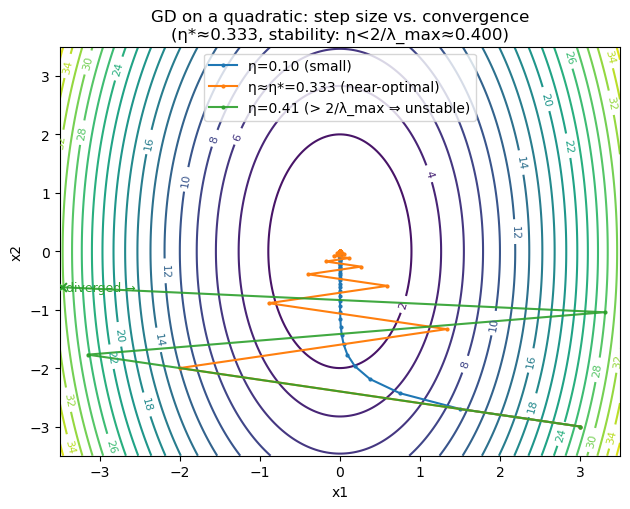

In [4]:
# Gradient Descent on a 2D Quadratic: stability vs. step size (fixed visuals)
import numpy as np
import matplotlib.pyplot as plt

Q = np.array([[5.0, 0.0],
              [0.0, 1.0]])

def f(x):   return 0.5 * x @ Q @ x
def grad(x): return Q @ x

eigvals = np.linalg.eigvalsh(Q)
mu, L = eigvals[0], eigvals[-1]
eta_star = 2.0 / (mu + L)
eta_max  = 2.0 / L

print(f"λ_min={mu:.3f}, λ_max={L:.3f}, κ={L/mu:.2f}")
print(f"η* (optimal fixed step) ≈ {eta_star:.3f}")
print(f"Stability requires 0 < η < {eta_max:.3f}")

def run_gd(x0, lr, steps=200):
    x = x0.copy()
    xs = [x.copy()]
    vals = [f(x)]
    for _ in range(steps):
        x = x - lr * grad(x)
        xs.append(x.copy())
        vals.append(f(x))
    return np.array(xs), np.array(vals)

x0 = np.array([3.0, -3.0])

# Choose LR: conservative, near-optimal, slightly-unstable (just above 2/L = 0.4)
lrs    = [0.10, eta_star, 0.41]
labels = [f"η={lrs[0]:.2f} (small)",
          f"η≈η*={lrs[1]:.3f} (near-optimal)",
          f"η={lrs[2]:.2f} (> 2/λ_max ⇒ unstable)"]

runs = [run_gd(x0, lr) for lr in lrs]

# Contours + trajectories (clip view, trim diverging path)
view = 3.5
grid = np.linspace(-view, view, 220)
X, Y = np.meshgrid(grid, grid)
Z = 0.5*(Q[0,0]*X**2 + 2*Q[0,1]*X*Y + Q[1,1]*Y**2)

plt.figure(figsize=(6.4, 5.2))
cs = plt.contour(X, Y, Z, levels=20)
plt.clabel(cs, inline=True, fontsize=8)

colors = ["tab:blue", "tab:orange", "tab:green"]
for (path, vals), lab, col in zip(runs, labels, colors):
    # If the run diverges, plot only the first K in-bounds steps to avoid autoscale blow-up
    in_bounds = np.all(np.abs(path) <= view, axis=1)
    if in_bounds.sum() == len(path):
        # stable: plot all
        plt.plot(path[:,0], path[:,1], marker="o", markersize=2, label=lab, color=col)
    else:
        # unstable: plot only first chunk inside the view window
        k = np.argmax(~in_bounds) # first out-of-bounds index
        k = max(k, 2) # at least two points to draw a segment
        plt.plot(path[:k,0], path[:k,1], marker="o", markersize=2, label=lab, color=col, alpha=0.9)
        # indicate it diverged
        last = path[k-1]
        plt.scatter(last[0], last[1], s=40, color=col, marker="x", zorder=3)
        plt.text(last[0], last[1], " diverged →", fontsize=9, color=col, va="center")

plt.title(f"GD on a quadratic: step size vs. convergence\n(η*≈{eta_star:.3f}, stability: η<2/λ_max≈{eta_max:.3f})")
plt.xlabel("x1"); plt.ylabel("x2")
plt.xlim(-view, view); plt.ylim(-view, view)
plt.legend()
plt.tight_layout()
plt.show()

## 2. Momentum & Nesterov Acceleration

Gradient Descent can oscillate on **valleys or ill-conditioned surfaces**. **Momentum** adds an *inertial term* that helps the optimizer move faster along consistent directions and dampen oscillations across steep walls.


### Momentum

We maintain a *velocity vector* $v_k$ that accumulates past gradients:

$$
v_{k+1} = \beta v_k + \nabla f(x_k), \qquad 
x_{k+1} = x_k - \eta v_{k+1},
$$

where  
- $ \beta \in [0,1) $ is the **momentum coefficient** (typically 0.9),  
- $ \eta $ is the learning rate.

**Intuition:**  
- The update combines the current gradient with a fraction of the previous direction.  
- Like pushing a ball down a hill — once it gains speed, small bumps don’t stop it.


### Nesterov Accelerated Gradient (NAG)

Nesterov’s idea is to look *ahead* before computing the gradient, giving smoother convergence:

$$
v_{k+1} = \beta v_k + \nabla f(x_k - \eta \beta v_k), \qquad 
x_{k+1} = x_k - \eta v_{k+1}.
$$

This “anticipatory” step makes NAG more stable and responsive — the optimizer slows down automatically near minima.


### Geometric Intuition

- Momentum smooths oscillations in narrow ravines.  
- NAG further improves by **predicting** where the next step will be.  
- Both reduce the zig-zag effect in poorly conditioned loss landscapes.


### RL Connection

| RL Concept | Optimization Analogy |
|-------------|---------------------|
| **Policy updates** | Momentum helps stabilize noisy gradients from sampled trajectories. |
| **Value network training** | NAG accelerates convergence when value loss surfaces are elongated. |
| **Actor–critic learning** | Critic updates can benefit from velocity terms to reduce variance in gradient flow. |
| **Adaptive methods (e.g., Adam)** | Combine momentum with per-parameter scaling for robust RL training. |

Momentum-based optimizers are crucial in RL because policy gradients are **noisy and high-variance** — accumulating direction information leads to smoother and faster learning.

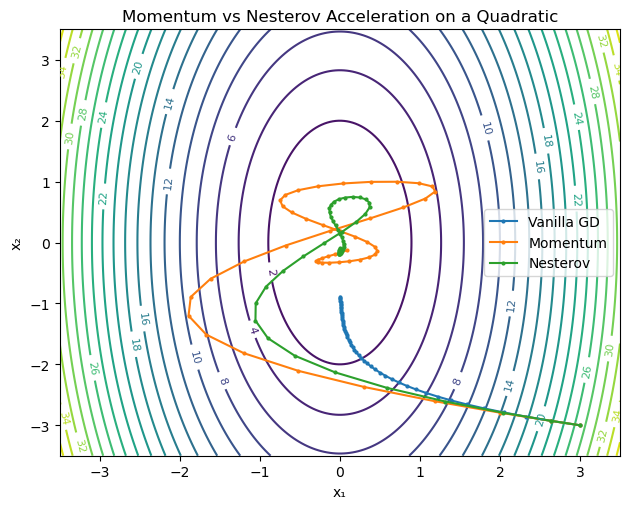

In [18]:
def run_optimizer(x0, lr, beta, steps=50, mode="momentum"):
    x = x0.copy()
    v = np.zeros_like(x)
    xs, vals = [x.copy()], [f(x)]
    for _ in range(steps):
        if mode == "momentum":
            v = beta * v + grad(x)
            x = x - lr * v
        elif mode == "nesterov":
            v = beta * v + grad(x - lr * beta * v)
            x = x - lr * v
        else:
            x = x - lr * grad(x)
        xs.append(x.copy())
        vals.append(f(x))
    return np.array(xs), np.array(vals)

x0 = np.array([3.0, -3.0])
lr = 0.024
beta = 0.9

runs = {
    "Vanilla GD": run_optimizer(x0, lr, beta, mode="gd"),
    "Momentum":   run_optimizer(x0, lr, beta, mode="momentum"),
    "Nesterov":   run_optimizer(x0, lr, beta, mode="nesterov")
}

# Contour plot with trajectories
grid = np.linspace(-3.5, 3.5, 200)
X, Y = np.meshgrid(grid, grid)
Z = 0.5 * (Q[0,0]*X**2 + 2*Q[0,1]*X*Y + Q[1,1]*Y**2)

plt.figure(figsize=(6.4, 5.2))
cs = plt.contour(X, Y, Z, levels=20)
plt.clabel(cs, inline=True, fontsize=8)

colors = ["tab:blue", "tab:orange", "tab:green"]
for (name, (path, vals)), c in zip(runs.items(), colors):
    plt.plot(path[:,0], path[:,1], marker="o", markersize=2, label=name, color=c)
plt.title("Momentum vs Nesterov Acceleration on a Quadratic")
plt.xlabel("x₁"); plt.ylabel("x₂")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Adaptive Methods — AdaGrad, RMSProp, Adam

Classical Gradient Descent uses a *single global learning rate* $ \eta $ for all parameters. However, different parameters may experience gradients of vastly different magnitudes. **Adaptive methods** address this by scaling updates using historical gradient information.


### AdaGrad

AdaGrad [(Duchi et. al, 2011)](https://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) accumulates the squared gradients for each parameter:

$$
g_t = \nabla_\theta f_t, \qquad
G_t = G_{t-1} + g_t^2, \qquad
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} g_t.
$$

- Coordinates with large gradients get smaller effective learning rates.  
- Works well for sparse features (e.g., text, embeddings).  
- Drawback: the accumulated $G_t$ keeps growing, causing vanishing steps.


### RMSProp

RMSProp [(Hinton, 2012)](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf) fixes AdaGrad’s decay issue by using an **exponential moving average**:

$$
v_t = \beta v_{t-1} + (1-\beta) g_t^2, \qquad
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{v_t + \epsilon}} g_t.
$$

- Smooths the gradient magnitude estimate.
- Prevents aggressive decay in learning rate.
- Common in non-stationary settings like RL.


### Adam

Adam [(Kingma et. al, 2014)](https://arxiv.org/pdf/1412.6980) combines **Momentum** and **RMSProp** — tracking both first and second moments:

$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1-\beta_1) g_t, \\
v_t &= \beta_2 v_{t-1} + (1-\beta_2) g_t^2, \\
\hat{m}_t &= \frac{m_t}{1-\beta_1^t}, \qquad
\hat{v}_t = \frac{v_t}{1-\beta_2^t}, \\
\theta_{t+1} &= \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}.
\end{aligned}
$$

- Momentum improves stability.  
- RMS scaling ensures robust adaptation.  
- Bias correction keeps early updates consistent.


### RL Connection

| RL Concept | Optimizer Analogy |
|-------------|-------------------|
| **Policy Gradient Updates** | Adam stabilizes noisy, high-variance policy gradients across episodes. |
| **Value Function Fitting** | RMSProp smooths non-stationary TD errors, aiding stable critic updates. |
| **Actor–Critic Methods** | Separate step-size adaptation for actor and critic encourages balanced learning. |
| **Exploration in Noisy Environments** | Adaptive step scaling helps avoid premature convergence to suboptimal policies. |

In [30]:
# Optimizer steps
def adagrad_step(x, g, G, lr=0.30, eps=1e-8):
    G = G + g*g
    x = x - lr * g / (np.sqrt(G) + eps)
    return x, G

def rmsprop_step(x, g, v, lr=0.20, beta=0.9, eps=1e-8):
    v = beta*v + (1-beta)*(g*g)
    x = x - lr * g / (np.sqrt(v) + eps)
    return x, v

def adam_step(x, g, m, v, t, lr=0.15, b1=0.9, b2=0.999, eps=1e-8):
    m = b1*m + (1-b1)*g
    v = b2*v + (1-b2)*(g*g)
    mhat = m / (1 - b1**t)
    vhat = v / (1 - b2**t)
    x = x - lr * mhat / (np.sqrt(vhat) + eps)
    return x, m, v

# Runners
def run_adagrad(x0, steps=80, lr=0.30, noise_std=0.10, clip_norm=None, seed=0):
    x = x0.astype(float).copy()
    G = np.zeros_like(x)
    rng = np.random.default_rng(seed)
    xs = [x.copy()]; losses = [f(x)]
    for _ in range(1, steps+1):
        g = grad(x) + noise_std * rng.normal(size=x.shape)
        if clip_norm:
            n = np.linalg.norm(g)
            if n > clip_norm: g *= (clip_norm/n)
        x, G = adagrad_step(x, g, G, lr=lr)
        xs.append(x.copy()); losses.append(f(x))
    return np.array(xs), np.array(losses)

def run_rmsprop(x0, steps=80, lr=0.20, beta=0.9, noise_std=0.10, clip_norm=None, seed=1):
    x = x0.astype(float).copy()
    v = np.zeros_like(x)
    rng = np.random.default_rng(seed)
    xs = [x.copy()]; losses = [f(x)]
    for _ in range(1, steps+1):
        g = grad(x) + noise_std * rng.normal(size=x.shape)
        if clip_norm:
            n = np.linalg.norm(g)
            if n > clip_norm: g *= (clip_norm/n)
        x, v = rmsprop_step(x, g, v, lr=lr, beta=beta)
        xs.append(x.copy()); losses.append(f(x))
    return np.array(xs), np.array(losses)

def run_adam(x0, steps=80, lr=0.15, b1=0.9, b2=0.999, noise_std=0.10, clip_norm=None, seed=2):
    x = x0.astype(float).copy()
    m = np.zeros_like(x); v = np.zeros_like(x)
    rng = np.random.default_rng(seed)
    xs = [x.copy()]; losses = [f(x)]
    for t in range(1, steps+1):
        g = grad(x) + noise_std * rng.normal(size=x.shape)
        if clip_norm:
            n = np.linalg.norm(g)
            if n > clip_norm: g *= (clip_norm/n)
        x, m, v = adam_step(x, g, m, v, t, lr=lr, b1=b1, b2=b2)
        xs.append(x.copy()); losses.append(f(x))
    return np.array(xs), np.array(losses)

AdaGrad LR: 0.25, RMSProp LR: 0.075, Adam LR: 0.05


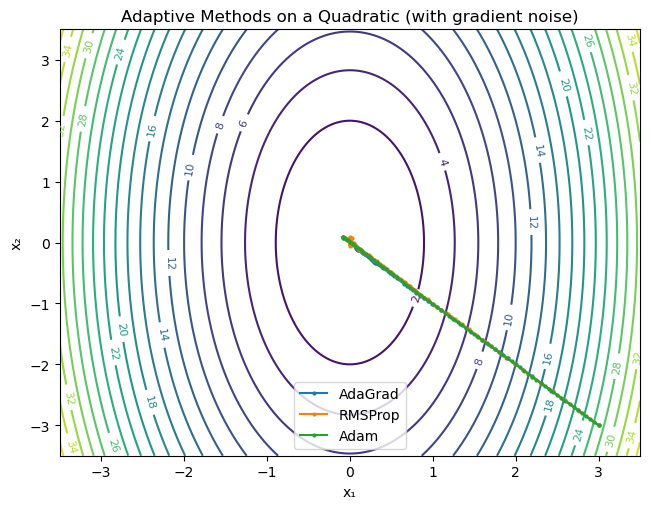

In [32]:
# Run all three on the same problem
x0 = np.array([3.0, -3.0])
paths = {}
losses = {}

paths["AdaGrad"], losses["AdaGrad"]   = run_adagrad(x0, lr=0.25, noise_std=0.10, clip_norm=5.0)
paths["RMSProp"], losses["RMSProp"]   = run_rmsprop(x0, lr=0.075, beta=0.9, noise_std=0.10, clip_norm=5.0)
paths["Adam"],    losses["Adam"]      = run_adam(x0, lr=0.05, b1=0.9, b2=0.999, noise_std=0.10, clip_norm=5.0)

print("AdaGrad LR: 0.25, RMSProp LR: 0.075, Adam LR: 0.05")

# Contours + trajectories
view = 3.5
grid = np.linspace(-view, view, 220)
X, Y = np.meshgrid(grid, grid)
Z = 0.5*(Q[0,0]*X**2 + 2*Q[0,1]*X*Y + Q[1,1]*Y**2)

plt.figure(figsize=(6.6, 5.2))
cs = plt.contour(X, Y, Z, levels=20)
plt.clabel(cs, inline=True, fontsize=8)
colors = {"AdaGrad":"tab:blue", "RMSProp":"tab:orange", "Adam":"tab:green"}
for name in ["AdaGrad","RMSProp","Adam"]:
    p = paths[name]
    plt.plot(p[:,0], p[:,1], marker="o", markersize=2, label=name, color=colors[name])
plt.title("Adaptive Methods on a Quadratic (with gradient noise)")
plt.xlabel("x₁"); plt.ylabel("x₂"); plt.xlim(-view, view); plt.ylim(-view, view)
plt.legend(); plt.tight_layout(); plt.show()

## 4. Schedules, Gradient Clipping, and Plateaus

### Learning Rate (LR) Schedules

A **learning rate schedule** adjusts the step size $\eta_k$ during training to balance **exploration** (large steps early) and **convergence** (smaller steps later).  
Common schedules:

$$
\eta_k = 
\begin{cases}
\eta_0 \cdot \gamma^{\lfloor k / s \rfloor}, & \text{(step decay)} \\
\eta_0 \cdot \frac{1}{\sqrt{k}}, & \text{(inverse-square-root decay)} \\
\eta_0 \cdot \frac{1}{2}\big(1 + \cos(\pi k / K)\big), & \text{(cosine decay)} 
\end{cases}
$$

- Large learning rates help escape flat regions or **plateaus** early on.  
- Gradual decay prevents oscillations near optima.  
- **Warm restarts** (e.g., cosine annealing) cyclically increase $\eta_k$ to promote exploration again.


### Gradient Clipping

To prevent instability when gradients explode, we clip the gradient norm:

$$
g \leftarrow g \cdot \frac{\tau}{\|g\|_2}, \quad \text{if } \|g\|_2 > \tau.
$$

- Stabilizes training in deep or recurrent networks.
- Prevents large parameter updates that could derail optimization.


### Plateaus and Flat Regions

During training, gradients may approach zero even far from optimality (common in sigmoid/tanh activations or deep credit assignment). Adaptive LR and momentum methods help “push through” these flat regions by maintaining accumulated update momentum or increasing effective step sizes.


### RL Connection

| RL Concept | Optimization Analogy |
|-------------|----------------------|
| **Policy Gradient Training** | LR schedules prevent premature convergence to suboptimal deterministic policies. |
| **Value Function Updates** | Clipping gradients stabilizes critic learning when TD errors explode. |
| **Actor–Critic Stability** | Small LR for critic, larger for actor — prevents feedback loops. |
| **Exploration Plateaus** | LR restarts or adaptive scaling can reintroduce exploration after stagnation. |

In practice, **Adam with gradient clipping** and **cosine decay** LR schedules are standard for modern deep RL algorithms (e.g., PPO, SAC, DDPG).

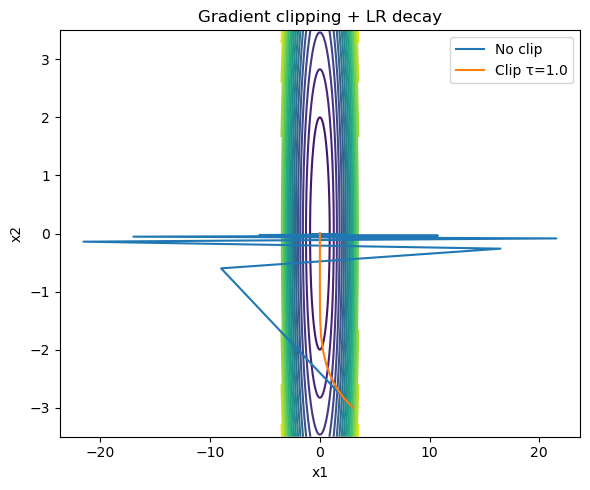

In [34]:
def run_gd_clip(x0, lr, steps=60, clip=None):
    x = x0.copy(); xs=[x.copy()]
    for k in range(1, steps+1):
        g = grad(x)
        if clip is not None:
            n = np.linalg.norm(g)
            if n > clip: g = g * (clip / n)
        eta = lr / np.sqrt(k)   # simple decay
        x = x - eta * g
        xs.append(x.copy())
    return np.array(xs)

clip_path = run_gd_clip(np.array([3.0,-3.0]), lr=0.8, steps=80, clip=1.0)
noclip_path = run_gd_clip(np.array([3.0,-3.0]), lr=0.8, steps=80, clip=None)

plt.figure(figsize=(6,5))
cs = plt.contour(X, Y, Z, levels=20)
plt.plot(noclip_path[:,0], noclip_path[:,1], label="No clip")
plt.plot(clip_path[:,0], clip_path[:,1], label="Clip τ=1.0")
plt.legend(); plt.title("Gradient clipping + LR decay")
plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout(); plt.show()

## 5. RL Tie-Ins — Policy Gradient & Critic Regression

Optimization is at the **core of reinforcement learning** — every policy or value function update ultimately involves minimizing or maximizing an objective via gradient-based methods.


### Policy Gradient — Maximizing Expected Return

The **policy gradient theorem** provides a principled way to adjust parameters $\theta$ of a stochastic policy $\pi_\theta(a|s)$ to maximize expected cumulative reward:

$$
J(\theta) = \mathbb{E}_{\pi_\theta}\Big[\sum_{t=0}^{\infty} \gamma^t R_t\Big].
$$

The gradient is:

$$
\nabla_\theta J(\theta)
= \mathbb{E}_{\pi_\theta}\!\big[\,\nabla_\theta \log \pi_\theta(a|s) \, G_t\,\big],
$$

where $G_t$ is the discounted return.  
In practice, we estimate this via Monte Carlo samples:

$$
\theta \leftarrow \theta + \eta \, \nabla_\theta \log \pi_\theta(a_t|s_t) \, G_t.
$$

**Connection to optimization:**
- It’s **stochastic gradient ascent** on $J(\theta)$.
- Techniques like **momentum**, **Adam**, and **gradient clipping** directly transfer here.
- LR schedules help stabilize policy updates and reduce variance.


### Critic Regression — Minimizing Value Error

The **critic** (value function approximator) is trained to minimize the mean-squared error between predicted and empirical returns:

$$
L(\phi) = \tfrac{1}{2}\, \mathbb{E}\big[(V_\phi(s_t) - G_t)^2\big].
$$

The gradient is:

$$
\nabla_\phi L = (V_\phi(s_t) - G_t) \, \nabla_\phi V_\phi(s_t),
$$

which is optimized using standard **gradient descent** or **Adam**.

**Connection to optimization:**
- Equivalent to supervised regression.
- Often uses smaller learning rates than the policy to ensure stable updates.
- Adaptive methods (Adam) handle noisy value targets well.


### Summary Table

| RL Component | Objective | Optimization Type | Update Rule |
|---------------|------------|-------------------|--------------|
| **Actor (Policy)** | Maximize expected return $J(\theta)$ | Gradient **ascent** | $\theta \leftarrow \theta + \eta \nabla_\theta \log \pi_\theta(a\|s) G_t$ |
| **Critic (Value Function)** | Minimize MSE $L(\phi)$ | Gradient **descent** | $\phi \leftarrow \phi - \eta (V_\phi - G_t)\nabla_\phi V_\phi$ |

## Key Takeaways
- **Step size controls stability**; conditioning dictates GD speed on quadratics.  
- **Momentum/Nesterov** reduce oscillations and speed up progress on ill-conditioned problems.  
- **Adaptive optimizers (Adam/RMSProp/AdaGrad)** tune per-parameter steps and handle noise.  
- **Schedules & clipping** mitigate exploding/vanishing gradients and plateaus.  
- In **RL**, these tools stabilize **policy gradients** and **critic training**.

**Next:** `00_gradient_descent_from_scratch.ipynb` → build your own GD/Momentum/Adam modules and apply them to regression & simple control tasks.